In [2]:
# import joblib

# # Add project root to the Python path
# import shap
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import mean_absolute_error, r2_score
# from catboost import CatBoostRegressor
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import cross_val_score, cross_validate

# from sklearn.base import clone

# import scipy.sparse

# # access utilities

# import sys
# from pathlib import Path

# # Adjust the system path to include the project root directory. 
# # It assumes the notebook is inside 'scripts/model_training'.
# project_root = Path.cwd().parents[1]
# sys.path.insert(0, str(project_root))

# # Import the project configuration settings.
# import config
# from config import RANDOM_SEED
# config.set_seed()

# # Import the DataPreprocessingPipeline class from 'utils' in 'scripts/preprocessing'.
# from utils import DataPreprocessingPipeline

/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Imports the necessary libraries and project-specific modules.
# --------------------------
# System and Utility Libraries
import joblib
import os
import sys
from pathlib import Path

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Machine Learning Algorithm Libraries
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model Evaluation and Selection Libraries
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

# Model Interpretation Libraries
from sklearn.inspection import partial_dependence

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set the project root path
project_root = Path.cwd().parents[0]

# Insert the project root path to the system path
sys.path.insert(0, str(project_root))

# Import configuration settings
import config
from config import RANDOM_SEED

# Set the random seed
config.set_seed()

# Import our custom utility functions
from utils import DataPreprocessingPipeline


In [6]:
# Use the load_data function from config to load .sas7bdat file
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

In [4]:
# Please update the below based on your specific need

target = 'LOV'
target_to_drop = ['WAITTIME_BINARY','LOV_BINARY']
        
# Instantiate the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df,target=target,target_to_drop=target_to_drop,percent_train=0.70,percent_val=0.15,percent_test=0.15,stratify=False)

# Run the pipeline
pipeline.run()

X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test

train_df = pipeline.train_df
validation_df = pipeline.validation_df
test_df = pipeline.test_df

y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
print("Length y_test",len(y_test))

X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed

feature_names = pipeline.feature_names

cleaned_emergency_df = pipeline.cleaned_emergency_df 
transformed_emergency_df = pipeline.transformed_emergency_df

# Ensure feature_names is treated as a list
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(17959, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(17959, 387)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (12571, 387)
X_train size: (12571, 386)
y_train size: (12571,)

validation_df size: (2693, 387)
X_validation size: (2693, 386)
y_validation size: (2693,)

test_df size: (2695, 387)
X_test size: (2695, 386)
y_test size: (2695,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully
Length y_test 2695


In [7]:
# Define Models for Evaluation
# ----------------------------
# Create a dictionary of default regression models to evaluate their performance.
models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_SEED),
    'XGBRegressor': XGBRegressor(random_state=RANDOM_SEED),
    'LGBMRegressor': LGBMRegressor(random_state=RANDOM_SEED, force_col_wise=True, verbosity=-1),
    'CatBoostRegressor': CatBoostRegressor(verbose=0, random_state=RANDOM_SEED)
}

# Implementing a ModelEvaluator class to evaluate and compare the performance of different models using cross-validation
# Evaluates the models, plots their performance, and saves the best model based on Mean Absolute Error (MAE)
# ----------------------
class ModelEvaluator:
    def __init__(self, models, X_train, y_train, cv=5):
        self.models = models
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv
        self.scorers = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'R2': 'r2'}

    def evaluate_models(self):
        """Evaluate all models and store their performance in a dictionary."""
        return {name: self._evaluate_model(model) for name, model in self.models.items()}

    def _evaluate_model(self, model):
        """Helper function to perform cross-validation and calculate MAE and R2."""
        cv_results = cross_validate(
            model, self.X_train, self.y_train, cv=self.cv, scoring=self.scorers
        )
        return {
            'MAE': -np.mean(cv_results['test_MAE']),
            'R2': np.mean(cv_results['test_R2'])
        }

    def plot_performance(self, performance):
        """Generate bar charts for MAE and R2 values of all models."""
        model_performance = {}
        for name, model in models.items():
            cv_results = cross_validate(model, X_train_preprocessed, y_train, cv=5,
                                        scoring=['neg_mean_absolute_error', 'r2'])
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            mean_r2 = cv_results['test_r2'].mean()
            #print(f"{name}:\n MAE: {mean_mae:.2f}, R-squared: {mean_r2:.2f}\n")
            model_performance[name] = mean_mae
            
   
        mae_values, r2_values = zip(*[(perf['MAE'], perf['R2']) for perf in performance.values()])
        
        # Sort the models based on MAE values in ascending order
        sorted_models = sorted(performance.keys(), key=lambda x: performance[x]['MAE'])
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot MAE values in sorted order
        ax1.barh(sorted_models, [performance[model]['MAE'] for model in sorted_models], color='skyblue', edgecolor='black')
        ax1.set(title='MAE Comparison', xlabel='MAE', ylabel='Models')
        ax1.invert_yaxis()
        
        # Plot R2 values in the same order as MAE
        ax2.barh(sorted_models, [performance[model]['R2'] for model in sorted_models], edgecolor='black', color='lightgreen')
        ax2.set(title='R2 Score Comparison', xlabel='R2 Score')
        ax2.invert_yaxis()
        
        plt.tight_layout()
        plt.show()

    def save_best_model(self, performance, directory="model_train"):
        """Identify the best model based on MAE and save it."""
        best_model_name = min(performance, key=lambda x: performance[x]['MAE'])
        best_model = self.models[best_model_name].fit(self.X_train, self.y_train)
        os.makedirs(directory, exist_ok=True)
        joblib.dump(best_model, os.path.join(directory, f"{best_model_name}.joblib"))
        print(f"Saved {best_model_name} model to {directory}")

    def model_results(self):
        model_results = []
        for name, model in self.models.items():
            cv_results = cross_validate(
                model, self.X_train, self.y_train, cv=self.cv, scoring=self.scorers
            )
            model_results.append({
                'Model Name': name,
                'MAE': -np.mean(cv_results['test_MAE']),
                'R2': np.mean(cv_results['test_R2']),
                'Is Best Model': 'No'  # Placeholder for the best model flag
            })
        # After evaluating all models, mark the best one
        best_mae = min(result['MAE'] for result in model_results)
        for result in model_results:
            result['Is Best Model'] = 'Yes' if result['MAE'] == best_mae else 'No'
        return pd.DataFrame(model_results)

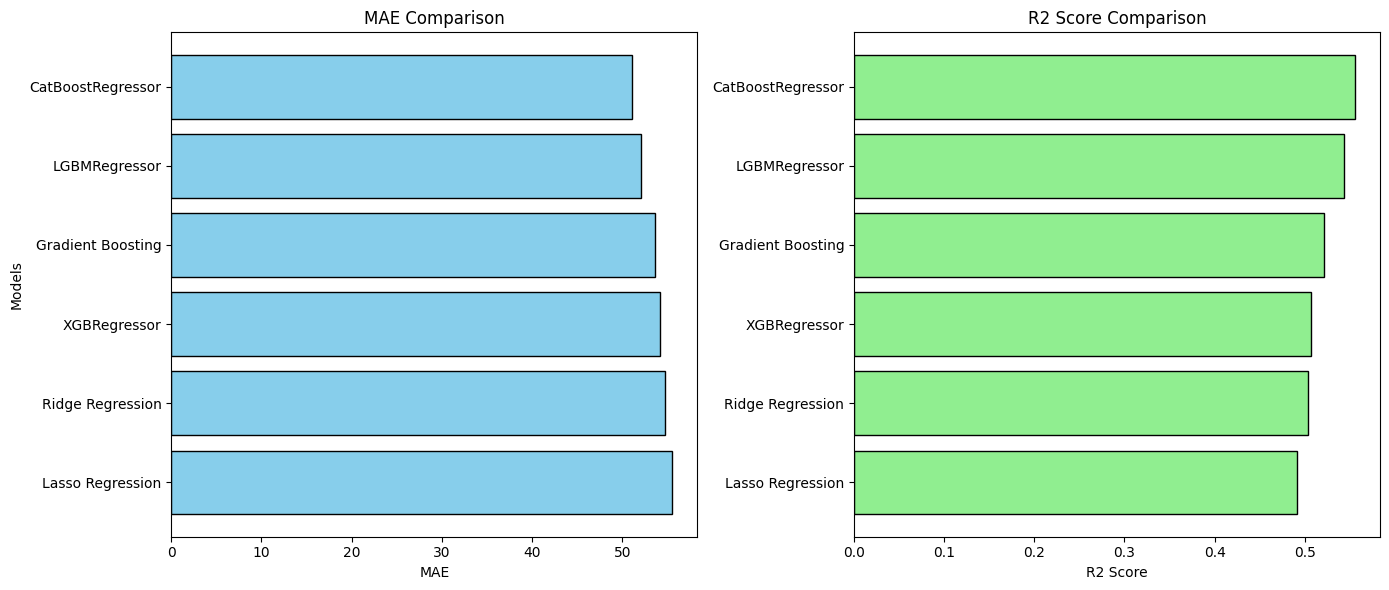

Saved CatBoostRegressor model to model_train


,Model Name,MAE,R2,Is Best Model
0,Ridge Regression,54.712919,0.503578,No
1,Lasso Regression,55.543151,0.491029,No
2,Gradient Boosting,53.688147,0.521718,No
3,XGBRegressor,54.149159,0.507396,No
4,LGBMRegressor,52.117715,0.543105,No
5,CatBoostRegressor,51.046661,0.555708,Yes


In [8]:
# Model Evaluation and Saving
# ---------------------------
evaluator = ModelEvaluator(models, pipeline.X_train_preprocessed, pipeline.y_train)
model_performance = evaluator.evaluate_models()
evaluator.plot_performance(model_performance)
evaluator.save_best_model(model_performance)
evaluator.model_results()

In [9]:
# Loads the tuned model and evaluates its performance on the test set
model_train_dir = "/Users/Macbook/Desktop/EDPredictiveEfficiency/scripts/models_training_and_selection/model_train/"
model_filename = "CatBoostRegressor.joblib"
model_file_path = os.path.join(model_train_dir, model_filename)
best_trained_model = joblib.load(model_file_path) if os.path.exists(model_file_path) else print(f"No such file found: {model_file_path}")


Most important features (Importance > 0.01):
            Feature  Importance
0          WAITTIME    0.129043
1           TOTDIAG    0.103249
2               CBC    0.025896
3           CSTRATM    0.024659
4          HOSPCODE    0.021107
5          IVFLUIDS    0.019408
6           BOARDED    0.018789
7           EMEDRES    0.018038
8             CPSUM    0.016502
9             PATWT    0.016422
10           NUMGIV    0.016388
11         DIAGSCRN    0.014798
12          CATSCAN    0.013265
13              AGE    0.012244
14            DIAG1    0.010412
15  ARRTIME_IN_HOUR    0.010272


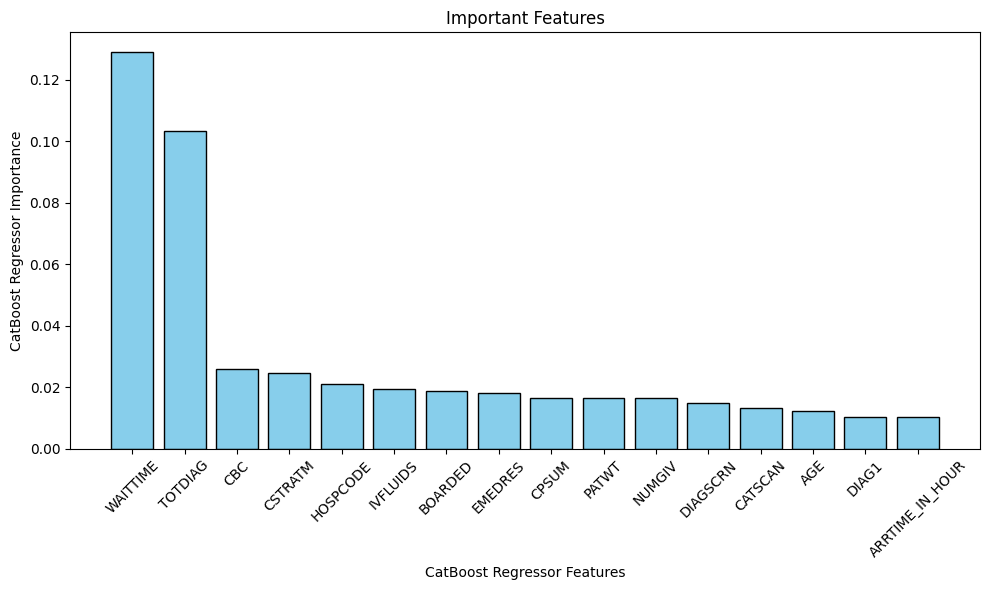

In [14]:
# Get feature importances from the trained model
feature_importances = best_trained_model.feature_importances_

# Normalize the feature importances
normalized_importances = feature_importances / np.sum(feature_importances)

# Create a dataframe with feature names and their normalized importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': normalized_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.reset_index(drop=True, inplace=True)
# Select the most important features based on a threshold
importance_threshold = 0.01 # (Importance > 0.01)
important_features_df = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]

print(f"\nMost important features (Importance > {importance_threshold}):")
print(important_features_df)

plt.figure(figsize=(10, 6))
plt.bar(important_features_df['Feature'], important_features_df['Importance'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel('CatBoost Regressor Features')
plt.ylabel('CatBoost Regressor Importance')
plt.title('Important Features')
plt.tight_layout()
plt.show()


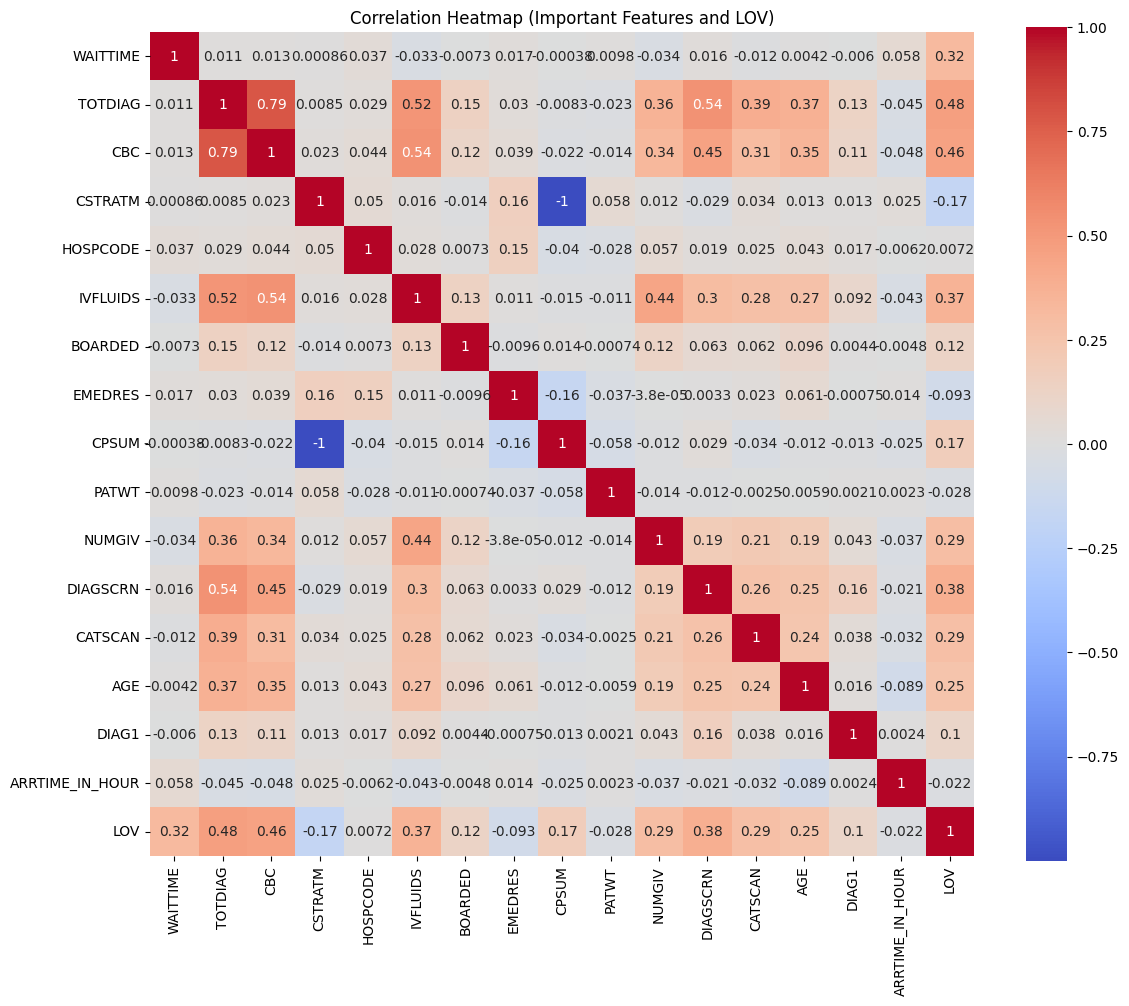

In [11]:
# Create a new DataFrame with the most important features and the target variable (LOV)
important_features_list = important_features_df['Feature'].tolist()
important_features_target_df = transformed_emergency_df[important_features_list + [target]]

# Calculate the correlation matrix
correlation_matrix = important_features_target_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap (Important Features and LOV)')
plt.tight_layout()
plt.show()

